# User Collection distance: Categories only

Using the tsne points as a representation of "boardgame similarity", create a function to calculate how similar the games in a user's collection are to each other. We consider only BGG category labels here.

1) Load user data

2) Load tsne points

3) Calculate all possible game-pair distances

4) Average each game-pair distance

## Load libraries and functions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Need to rewrite Rating Threshold to work with the csv files.
#Since the csv files load in N/A values as NaN, we just need to change each
#N/A to isnull() checks

def RatingThreshold(collection):
    
    print('Collection Size start: ' + str(collection.shape[0]))
    
    # First remove any games that have no User Rating and no BGG rating
    na_idx = collection[(collection['User rating'].isnull()) & (collection['BGG rating'].isnull())].index.tolist() #Grab indices of N/A User and BGG rating rows
    collection.drop(collection.index[na_idx], inplace=True)
    
    print('Collection Size after removing N/A ratings: ' + str(collection.shape[0]))
    
    # Remove any games with User rating < 7
    #Ratings are stored as strings to account for N/A rating
    #Convert column to numeric using pandas to_numeric function
    #Set errors to 'coerce' which turns non-numeric strings to NaN values, which will work for numeric comparisons

    #Keep if User rating == N/A (for BGG based comparison) and User rating >= 7
    collection = collection[(collection['User rating'].isnull()) | (pd.to_numeric(collection['User rating'], errors='coerce') >= 7)]
    
    print('Collection Size after removing low User ratings: ' + str(collection.shape[0]))
    
    #Reset index
    collection.reset_index(drop=True, inplace=True)
    
    # Remove any games with BGG rating < 7 (if there is no User Rating)
    #Similarly, convert BGG rating column to_numeric
    #Find row indices where User rating == N/A and BGG rating < 7
    #Drop relevant rows from DataFrame
    low_bgg_idx = collection[(collection['User rating'].isnull()) & (pd.to_numeric(collection['BGG rating'], errors='coerce') < 7)].index.tolist()
    collection.drop(collection.index[low_bgg_idx],inplace=True)
    
    collection.reset_index(drop=True, inplace=True)
    
    print('Collection Size after removing low BGG ratings (if no User rating available): ' + str(collection.shape[0]))
    
    return collection

# Categories only

### Load TSNE coordinates

In [3]:
# Get tsne
ga_tsne = pd.read_csv('bgg cat-only tsne coordinates.csv')

#Drop the first column (just indices)
ga_tsne.drop('Unnamed: 0', inplace=True, axis=1)

ga_tsne[['Ax1','Ax2']] = ga_tsne[['Ax1','Ax2']].apply(pd.to_numeric)

In [4]:
ga_tsne.head()

,Game name,Ax1,Ax2
0,Pandemic Legacy: Season 1,-1.415813,1.508416
1,Through the Ages: A New Story of Civilization,-3.399848,0.535843
2,Twilight Struggle,3.431175,0.528335
3,Gloomhaven,-0.270665,-1.992843
4,Star Wars: Rebellion,-5.585417,-2.762233


## Draft code for a single user

#### Load user

In [5]:
# Get a user list: Use user #105
playerlist = pd.read_excel('playerlist.xlsx')
user = playerlist['Username'][105]
file = str(user) + '_raw.csv'

user_collection = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')

# Clean the collection

# Drop the column 'Unnamed: 0' that is used to number the rows
user_collection.drop('Unnamed: 0', inplace=True, axis=1)
    
# Apply RatingThreshold
user_collection_cleaned = RatingThreshold(user_collection)

games = user_collection_cleaned['Game']

Collection Size start: 125
Collection Size after removing N/A ratings: 123
Collection Size after removing low User ratings: 88
Collection Size after removing low BGG ratings (if no User rating available): 57


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
user_collection.head()

#### Calculate all distances in the collection
(Single user draft)

In [7]:
dist = []

for i in np.arange(0,len(games)):
    g1 = games[i]
    
    if g1 in ga_tsne['Game name'].values:
        g1_x = ga_tsne[ga_tsne['Game name'] == g1]['Ax1'].iloc[0]
        g1_y = ga_tsne[ga_tsne['Game name'] == g1]['Ax2'].iloc[0]

        for j in np.arange(i+1, len(games)):
            g2 = games[j]
            
            if g2 in ga_tsne['Game name'].values:
                g2_x = ga_tsne[ga_tsne['Game name'] == g2]['Ax1'].iloc[0]
                g2_y = ga_tsne[ga_tsne['Game name'] == g2]['Ax2'].iloc[0]

                d = (g1_x - g2_x)**2 + (g1_y - g2_y)**2

                dist = dist + [d]

In [8]:
len(dist)

1035

In [9]:
# Averages distance
np.mean(dist)

30.614251237224817

## Define the function
Given a user and tsne coordinates of games, calculate the average similarity of the games in the user collection

In [10]:
def collection_distance(user, tsne):
    '''Provided a username in our playerlist and the tsne/game coordinate file,
    return the average distance/dissimilarity score of the user's collection'''
    
    # Get user collection
    file = str(user) + '_raw.csv'

    user_collection = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')
    
    # Clean the collection
    # Drop the column 'Unnamed: 0' that is used to number the rows
    user_collection.drop('Unnamed: 0', inplace=True, axis=1)

    # Apply RatingThreshold
    user_collection_cleaned = RatingThreshold(user_collection)

    games = user_collection_cleaned['Game']
    
#     #Drop the first column (just indices)
#     tsne.drop('Column1', inplace=True, axis=1)

#     #Rename headers with the actual headings (stored in first row)
#     tsne.rename(columns=tsne.iloc[0], inplace=True)
#     tsne.drop(0, inplace=True, axis=0)
#     tsne.reset_index(drop=True, inplace=True)

#     tsne[['Ax1','Ax2']] = ga_tsne[['Ax1','Ax2']].apply(pd.to_numeric)
    
    dist = []

    for i in np.arange(0,len(games)):
        g1 = games[i]

        if g1 in tsne['Game name'].values:
            g1_x = tsne[tsne['Game name'] == g1]['Ax1'].iloc[0]
            g1_y = tsne[tsne['Game name'] == g1]['Ax2'].iloc[0]

            for j in np.arange(i+1, len(games)):
                g2 = games[j]

                if g2 in tsne['Game name'].values:
                    g2_x = tsne[tsne['Game name'] == g2]['Ax1'].iloc[0]
                    g2_y = tsne[tsne['Game name'] == g2]['Ax2'].iloc[0]

                    d = (g1_x - g2_x)**2 + (g1_y - g2_y)**2

                    dist = dist + [d]
    
    return np.mean(dist)

## Apply to all users in a loop

In [ ]:
# Get a user list
playerlist = pd.read_excel('playerlist.xlsx')

# Get tsne coordinates
#Get tsne
ga_tsne = pd.read_csv('bgg cat-only tsne coordinates.csv')

#Drop the first column (just indices)
ga_tsne.drop('Unnamed: 0', inplace=True, axis=1)

ga_tsne[['Ax1','Ax2']] = ga_tsne[['Ax1','Ax2']].apply(pd.to_numeric)

# Storage dataframe
user_collection_dissimilarity = pd.DataFrame(0, index=np.arange(playerlist.shape[0]), columns=['User','Avg Category Dissimilarity'])

for i in np.arange(0,playerlist.shape[0]):
    print(i)
    user = playerlist['Username'][i]
    
    user_dist = collection_distance(user, ga_tsne)
    
    user_collection_dissimilarity.loc[i, 'User'] = user
    user_collection_dissimilarity.loc[i, 'Avg Category Dissimilarity'] = user_dist

In [12]:
user_collection_dissimilarity['Avg Category Dissimilarity'].mean()

37.93789571949147

In [13]:
user_collection_dissimilarity['Avg Category Dissimilarity'].min()

0.030948094753137895

In [14]:
user_collection_dissimilarity['Avg Category Dissimilarity'].max()

79.03551138151677

#### Let's histogram this

In [15]:
# There are NaN values in our dataset; let's remove them
nan_collections = user_collection_dissimilarity[user_collection_dissimilarity['Avg Category Dissimilarity'].isnull()]

In [16]:
clean_collections = user_collection_dissimilarity.drop(nan_collections.index.values)

(array([  2.,   1.,   2.,   2.,   2.,   7.,  20.,  30.,  37.,  40.,  27.,
         16.,  13.,   2.,   1.,   2.,   1.,   0.,   1.]),
 array([  0.        ,   4.21052632,   8.42105263,  12.63157895,
         16.84210526,  21.05263158,  25.26315789,  29.47368421,
         33.68421053,  37.89473684,  42.10526316,  46.31578947,
         50.52631579,  54.73684211,  58.94736842,  63.15789474,
         67.36842105,  71.57894737,  75.78947368,  80.        ]),
 <a list of 19 Patch objects>)

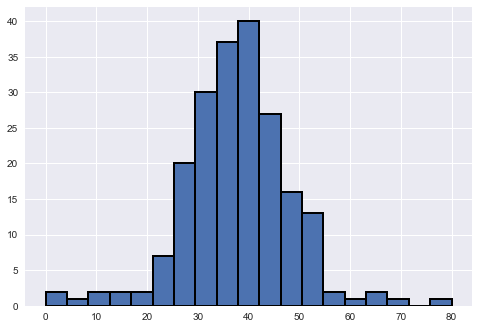

In [17]:
plt.hist(clean_collections['Avg Category Dissimilarity'].tolist(), bins=np.linspace(0,80,20),edgecolor='black',linewidth=2.0)

## Modify collection distance to use euclidean distances

In [29]:
def collection_euc_distance(user, game_attributes):
    '''Provided a username in our playerlist and the tsne/game coordinate file,
    return the average distance/dissimilarity score of the user's collection'''
    
    # Get user collection
    file = str(user) + '_raw.csv'

    user_collection = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')
    
    # Clean the collection
    # Drop the column 'Unnamed: 0' that is used to number the rows
    user_collection.drop('Unnamed: 0', inplace=True, axis=1)

    # Apply RatingThreshold
    user_collection_cleaned = RatingThreshold(user_collection)

    games = user_collection_cleaned['Game']
        
    dist = []

    for i in np.arange(0,len(games)):
        g1 = games[i]

        if g1 in game_attributes['Game name'].values:
            g1_coord = game_attributes[game_attributes['Game name'] == g1].iloc[0,1:].as_matrix()
            
            for j in np.arange(i+1, len(games)):
                g2 = games[j]

                if g2 in game_attributes['Game name'].values:
                    g2_coord = game_attributes[game_attributes['Game name']==g2].iloc[0,1:].as_matrix()

                    d = np.sqrt(np.square(g1_coord-g2_coord).sum()) # Distance calculation
                    
                    dist = dist + [d]
    
    return np.mean(dist)

In [ ]:
# Get a user list
playerlist = pd.read_excel('playerlist.xlsx')

# Load game attributes csv
ga = pd.read_csv('bgg game attributes edited.csv')
# Remodel the csv
#Drop the first column (just indices)
ga.drop('Column1', inplace=True, axis=1)
#Rename headers with the actual headings (stored in first row)
ga.rename(columns=ga.iloc[0], inplace=True)
ga.drop(0, inplace=True, axis=0)
ga.reset_index(drop=True, inplace=True)
#Set up scaling; remove text
ga_to_pca = ga.drop(['Game name','Game rank','Game ID','total categories','total mechanics'], axis=1)
# Normalize the non-binary values: #players, playtime, weight
#Import sklearn standardscaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Fit and Transform via standard scaler
scaler.fit(ga_to_pca[['#players','playtime','weight']])
scaled_ga = scaler.transform(ga_to_pca[['#players','playtime','weight']])
#Concatenate the normalized columns to the binary columns
scaled_ga = pd.concat([pd.DataFrame(scaled_ga, columns=['#players','playtime','weight']),ga_to_pca.drop(['#players','playtime','weight'],axis=1)],axis=1)
scaled_ga = scaled_ga.astype('float64')
# Add game names back on
scaled_cat = pd.concat([ga['Game name'],scaled_ga.loc[:,'#players':'weight'],scaled_ga.loc[:,'Abstract Strategy':'Zombies']],axis=1)

# Storage dataframe
user_collection_euc_distances = pd.DataFrame(0, index=np.arange(playerlist.shape[0]), columns=['User','Avg Category Euc Distance'])

for i in np.arange(0,playerlist.shape[0]):
    print(i)
    user = playerlist['Username'][i]
    
    user_dist = collection_euc_distance(user, scaled_cat)
    
    user_collection_euc_distances.loc[i, 'User'] = user
    user_collection_euc_distances.loc[i, 'Avg Category Euc Distance'] = user_dist

In [31]:
user_collection_euc_distances['Avg Category Euc Distance'].max()

3.3769625582139291

In [32]:
user_collection_euc_distances['Avg Category Euc Distance'].min()

1.7228079006020618

In [34]:
# There are NaN values in our dataset; let's remove them
nan_collections = user_collection_euc_distances[user_collection_euc_distances['Avg Category Euc Distance'].isnull()]

In [35]:
clean_euc_collections = user_collection_euc_distances.drop(nan_collections.index.values)

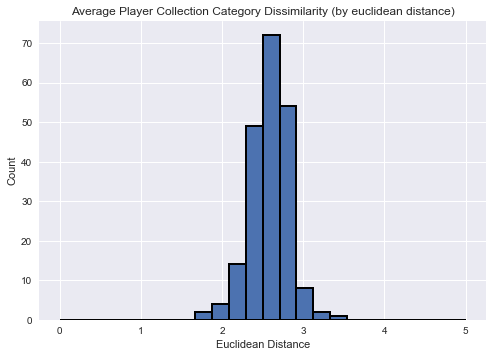

In [36]:
plt.hist(clean_euc_collections['Avg Category Euc Distance'].tolist(), bins=np.linspace(0,5,25),edgecolor='black',linewidth=2.0)
plt.xlabel('Euclidean Distance')
plt.ylabel('Count')
plt.title('Average Player Collection Category Dissimilarity (by euclidean distance)')

In [37]:
user_collection_euc_distances['Avg Category Euc Distance'].median()

2.5866693433273893

In [ ]:
user_collection_dissimilarity.head()

In [ ]:
user_collection_euc_distances.head()

In [41]:
# For output
out = pd.concat([user_collection_dissimilarity, user_collection_euc_distances.loc[:,'Avg Category Euc Distance']],axis=1)

In [42]:
out.to_csv('user collection cat-only dissimilarity.csv')

## Range of Dissimilarity

### TSNE

Load the tsne, and compare every game to each other

Start with the tsne file: ga_tsne

In [2]:
import math

# Get tsne
ga_tsne = pd.read_csv('bgg cat-only tsne coordinates.csv')

#Drop the first column (just indices)
ga_tsne.drop('Unnamed: 0', inplace=True, axis=1)

ga_tsne[['Ax1','Ax2']] = ga_tsne[['Ax1','Ax2']].apply(pd.to_numeric)

In [3]:
#Let's just calculate distances for top 1000 games as a proof of concept
ga_tsne = ga_tsne.iloc[0:1000]

In [4]:
# Number comparisons needed
total = int(math.factorial(ga_tsne.shape[0]) / (math.factorial(2) * math.factorial(ga_tsne.shape[0]-2)))
print(total)

499500


In [ ]:
idx = 0

total = int(math.factorial(ga_tsne.shape[0]) / (math.factorial(2) * math.factorial(ga_tsne.shape[0]-2)))

game_dissimilarities = pd.DataFrame(0, index=np.arange(total), columns=['Game 1','Game 2', 'Dissimilarity'])

dist = []

for i in np.arange(0,ga_tsne.shape[0]):    
    g1 = ga_tsne['Game name'][i]

    g1_x = ga_tsne[ga_tsne['Game name'] == g1]['Ax1'].iloc[0]
    g1_y = ga_tsne[ga_tsne['Game name'] == g1]['Ax2'].iloc[0]

    for j in np.arange(i+1, ga_tsne.shape[0]):
        g2 = ga_tsne['Game name'][j]
            
        g2_x = ga_tsne[ga_tsne['Game name'] == g2]['Ax1'].iloc[0]
        g2_y = ga_tsne[ga_tsne['Game name'] == g2]['Ax2'].iloc[0]

        d = (g1_x - g2_x)**2 + (g1_y - g2_y)**2

        dist = dist + [d]
            
        game_dissimilarities.loc[idx, 'Game 1'] = g1
        game_dissimilarities.loc[idx, 'Game 2'] = g2
        game_dissimilarities.loc[idx, 'Dissimilarity'] = d
            
        print(idx)
        idx += 1

In [6]:
game_dissimilarities.to_csv('Top1000 Game tsne Dissimilarities cat-only.csv', encoding='utf-8')

In [7]:
game_dissimilarities.head()

,Game 1,Game 2,Dissimilarity
0,Pandemic Legacy: Season 1,Through the Ages: A New Story of Civilization,4.882290
1,Pandemic Legacy: Season 1,Twilight Struggle,24.453850
2,Pandemic Legacy: Season 1,Gloomhaven,13.570176
3,Pandemic Legacy: Season 1,Star Wars: Rebellion,35.624030
4,Pandemic Legacy: Season 1,Terra Mystica,4.647671


In [8]:
game_dissimilarities['Dissimilarity'].describe()

count    4.995000e+05
mean     4.080328e+01
std      3.807004e+01
min      1.261027e-07
25%      1.166302e+01
50%      2.858188e+01
75%      6.017712e+01
max      2.255934e+02
Name: Dissimilarity, dtype: float64

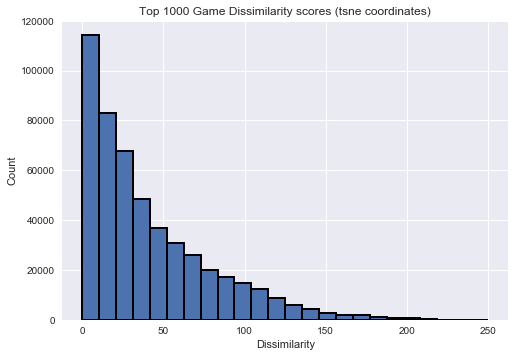

In [9]:
plt.hist(game_dissimilarities['Dissimilarity'].tolist(), bins=np.linspace(0,250,25),edgecolor='black',linewidth=2.0)
plt.xlabel('Dissimilarity')
plt.ylabel('Count')
plt.title('Top 1000 Game Dissimilarity scores (tsne coordinates)')

### Euclidean distance

In [10]:
# Load game attributes csv
ga = pd.read_csv('bgg game attributes edited.csv')

# Remodel the csv
#Drop the first column (just indices)
ga.drop('Column1', inplace=True, axis=1)
#Rename headers with the actual headings (stored in first row)
ga.rename(columns=ga.iloc[0], inplace=True)
ga.drop(0, inplace=True, axis=0)
ga.reset_index(drop=True, inplace=True)
#Set up scaling; remove text
ga_to_pca = ga.drop(['Game name','Game rank','Game ID','total categories','total mechanics'], axis=1)
# Normalize the non-binary values: #players, playtime, weight
#Import sklearn standardscaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Fit and Transform via standard scaler
scaler.fit(ga_to_pca[['#players','playtime','weight']])
scaled_ga = scaler.transform(ga_to_pca[['#players','playtime','weight']])
#Concatenate the normalized columns to the binary columns
scaled_ga = pd.concat([pd.DataFrame(scaled_ga, columns=['#players','playtime','weight']),ga_to_pca.drop(['#players','playtime','weight'],axis=1)],axis=1)
scaled_ga = scaled_ga.astype('float64')
# Add game names back on
scaled_cat = pd.concat([ga['Game name'],scaled_ga.loc[:,'#players':'weight'],scaled_ga.loc[:,'Abstract Strategy':'Zombies']],axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# Take only the top 1000 games
df = scaled_cat.iloc[0:1000]

In [12]:
# Sample calculation
g1 = df['Game name'][0]

g1_coord = df.iloc[0,1:].as_matrix()
g2_coord = df.iloc[1,1:].as_matrix()

# Distance calculation
np.sqrt(np.square(g1_coord-g2_coord).sum())

2.9423048661102338

In [ ]:
idx = 0

total = int(math.factorial(df.shape[0]) / (math.factorial(2) * math.factorial(df.shape[0]-2)))

game_distances = pd.DataFrame(0, index=np.arange(total), columns=['Game 1','Game 2', 'Distance'])

dist = []

for i in np.arange(0,df.shape[0]):    
    g1 = df['Game name'][i] #Get first game name

    g1_coord = df.iloc[i,1:].as_matrix() #Get first game coordinates

    for j in np.arange(i+1, df.shape[0]):
        g2 = df['Game name'][j] #Get second game name
            
        g2_coord = df.iloc[j,1:].as_matrix() #Get second game coordinates
        
        d = np.sqrt(np.square(g1_coord-g2_coord).sum()) # Distance calculation

        dist = dist + [d]
            
        game_distances.loc[idx, 'Game 1'] = g1
        game_distances.loc[idx, 'Game 2'] = g2
        game_distances.loc[idx, 'Distance'] = d
            
        print(idx)
        idx += 1

In [14]:
game_distances.to_csv('Top1000 Game Euclidean Distances cat-only.csv',encoding='utf-8')

In [15]:
game_distances.describe()

,Distance
count,499500.000000
mean,2.727162
std,1.057812
min,0.001307
25%,2.257775
50%,2.648394
75%,3.031630
max,20.652781


(array([  8.05000000e+02,   2.42670000e+04,   2.18345000e+05,
          2.09938000e+05,   3.72540000e+04,   3.68100000e+03,
          8.94000000e+02,   2.27300000e+03,   4.60000000e+01,
          2.00000000e+00,   6.20000000e+01,   8.12000000e+02,
          1.20000000e+02,   3.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.00000000e+00,
          8.30000000e+01,   9.08000000e+02,   3.00000000e+00]),
 array([  0.   ,   0.875,   1.75 ,   2.625,   3.5  ,   4.375,   5.25 ,
          6.125,   7.   ,   7.875,   8.75 ,   9.625,  10.5  ,  11.375,
         12.25 ,  13.125,  14.   ,  14.875,  15.75 ,  16.625,  17.5  ,
         18.375,  19.25 ,  20.125,  21.   ]),
 <a list of 24 Patch objects>)

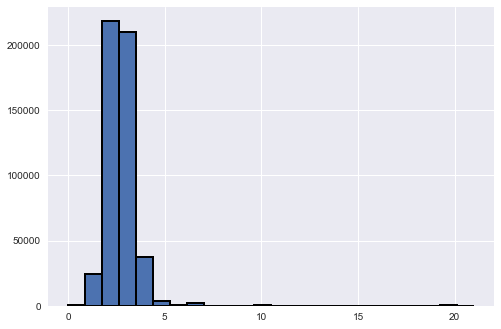

In [18]:
plt.hist(game_distances['Distance'].tolist(), bins=np.linspace(0,21,25),edgecolor='black',linewidth=2.0)

In [19]:
game_distances['Distance'].median()

2.6483942611170375